## Summary
(1) The key to build a dense network is to define a mode class that reflect the structure of the network.   
(2) To train the model, we define the for loops ourselves. For each batch, there are several typical steps: prediction, calculating loss, backpropagation, update parameter, set gradients to zeros.   
(3) Several new functions are used: sigmoid, softmax, cross-entropy.   
(4) Save and load the trained model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import torch

In [2]:
# Load iris dataset
iris = load_iris()
X = iris['data']
y = iris['target']

In [3]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1.0/3.0, 
                                                    random_state=1, stratify=y) 

In [4]:
# Normalization and conversion to tensors
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm_tensor = torch.from_numpy(X_train_norm).float() # Convert to float32

y_train_tensor = torch.from_numpy(y_train) # No need to convert y_train

In [5]:
# Explanations on the above codes
iris['feature_names']
# We can see that the four features are all about lengths. Therefore we can normalize the features by the mean of all X data.

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [6]:
# Create dataset and dataloader
batch_size = 2
dataset_train = torch.utils.data.TensorDataset(X_train_norm_tensor, y_train_tensor)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

In [7]:
# Define a fully connected network (dense network)
class Model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = torch.nn.Linear(input_size, hidden_size)
        self.layer2 = torch.nn.Linear(hidden_size, output_size)
    def forward(self, X):
        # When X is a 2D tensor containing multiple examples, self.layer1 is applied to each row of X
        X = self.layer1(X)
        # torch.nn.Sigmoid applies sigmoid function to each entry in X
        X = torch.nn.Sigmoid()(X)
        X = self.layer2(X)
        # torch.nn.Softmax converts each row of X into probabilities so that each row sums up to 1.
        X = torch.nn.Softmax(dim=1)(X)
        return X

In [8]:
# The input size is the number of features
input_size = X_train.shape[1]
# The hidden size is the number of neurons in the hidden layer, specified by the user
hidden_size = 16
# The output size is the number of labels
output_size = len(np.unique(y_train))

model = Model(input_size, hidden_size, output_size)

In [9]:
# Create loss function and optimizer
# torch.nn.CrossEntropyLoss(reduction='mean')(prediction, y_label):
# prediction's shape is (num_examples, num_classes). It contains the predicted class probabilities of the examples.
# y_label's shape is (num_examples,). It contains the true labels of the examples.
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Train the model
num_epoch = 200

# Lists to store the histories of loss and accuracy
loss_list = [0] * num_epoch
accuracy_list = [0] * num_epoch

# Number of batches and examples, used for calculating averages
num_batch = len(dataloader_train.dataset)/batch_size

# Train the model
for epoch in range(num_epoch):
    for x_batch, y_batch in dataloader_train:
        prediction = model(x_batch)
        loss = loss_fn(prediction, y_batch.long()) # y_batch.long() converts y_batch into long int. Without the conversion there will be error message.
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_list[epoch] += loss.item()
        # torch.argmax(prediction, dim=1) returns the label of the maximum entry along each row
        # The result is a 1D tensor with the same shape as y_batch
        # torch.argmax(prediction, dim=1) == y_batch returns a boolean matrix
        is_correct = (torch.argmax(prediction, dim=1) == y_batch).float()
        accuracy_list[epoch] += is_correct.mean()
    
    # The loss for each batch is an average over the batch. Therefore we divide it by the number of batches instead of the number of examples
    # Similary, the accuracy is divided by the number of batches.
    loss_list[epoch] /= num_batch
    accuracy_list[epoch] /= num_batch
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss {loss_list[epoch]} Accuracy {accuracy_list[epoch]}")

Epoch 0, Loss 0.5952386093139649 Accuracy 0.9599999785423279
Epoch 10, Loss 0.5927619647979736 Accuracy 0.9700000286102295
Epoch 20, Loss 0.5917299032211304 Accuracy 0.9700000286102295
Epoch 30, Loss 0.5907225549221039 Accuracy 0.9700000286102295
Epoch 40, Loss 0.5906791305541992 Accuracy 0.9700000286102295
Epoch 50, Loss 0.5882589030265808 Accuracy 0.9700000286102295
Epoch 60, Loss 0.5876824724674224 Accuracy 0.9700000286102295
Epoch 70, Loss 0.5867908024787902 Accuracy 0.9700000286102295
Epoch 80, Loss 0.5862127125263215 Accuracy 0.9700000286102295
Epoch 90, Loss 0.5863092339038849 Accuracy 0.9700000286102295
Epoch 100, Loss 0.5853875827789307 Accuracy 0.9700000286102295
Epoch 110, Loss 0.5842335605621338 Accuracy 0.9700000286102295
Epoch 120, Loss 0.5842135059833526 Accuracy 0.9700000286102295
Epoch 130, Loss 0.5836724698543548 Accuracy 0.9700000286102295
Epoch 140, Loss 0.5832864689826965 Accuracy 0.9700000286102295
Epoch 150, Loss 0.5827405047416687 Accuracy 0.9700000286102295
Epo

Text(0, 0.5, 'Accuracy')

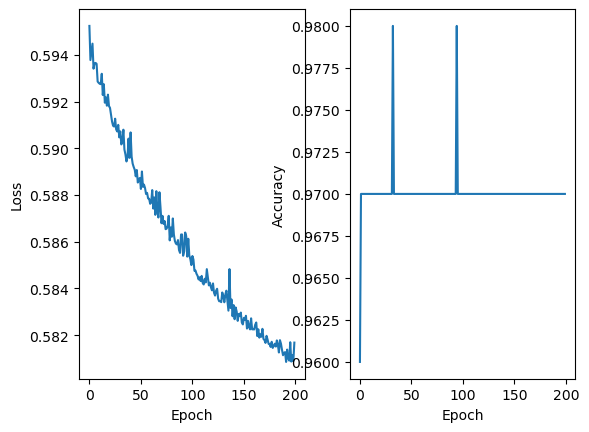

In [13]:
# Show the loss and accuracy
fig = plt.figure()
ax = fig.add_subplot(121)

ax.plot(loss_list)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

ax = fig.add_subplot(122)
ax.plot(accuracy_list)
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")

In [14]:
# Evaluate model on the test set
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm_tensor = torch.from_numpy(X_test_norm).float()
y_test_tensor = torch.from_numpy(y_test)
prediction_test = model(X_test_norm_tensor)

is_correct = (torch.argmax(prediction_test, dim=1) == y_test_tensor).float()
accuracy = is_correct.mean()

print('Accuracy on the test set:', accuracy)

Accuracy on the test set: tensor(0.9600)


## Saving and reloading the trained model

In [17]:
# Save the model
path = 'saved_model/iris_classifier.pt'
torch.save(model, path)

In [18]:
# Load the model
model_saved = torch.load(path)

In [19]:
# Show the model structure
model_saved.eval()

Model(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)

In [20]:
# Test the saved model's accuracy
prediction_test = model_saved(X_test_norm_tensor)
is_correct = (torch.argmax(prediction_test, dim=1) == y_test_tensor).float()
accuracy = is_correct.mean()
print('Accuracy on the test set:', accuracy)

Accuracy on the test set: tensor(0.9600)


In [21]:
# Only save the learned parameters
path = 'saved_model/iris_classifier_state.pt'
torch.save(model.state_dict(), path)

In [22]:
# Create a new model and assign the saved paramter values to this model
model_new = Model(input_size, hidden_size, output_size)
model_new.load_state_dict(torch.load(path))

<All keys matched successfully>

In [24]:
# Test the new model's accuracy
prediction_test = model_new(X_test_norm_tensor)
is_correct = (torch.argmax(prediction_test, dim=1) == y_test_tensor).float()
accuracy = is_correct.mean()
print('Accuracy on the test set:', accuracy)

Accuracy on the test set: tensor(0.9600)
